<a href="https://colab.research.google.com/github/shadfdz/speechEmotionRecognition/blob/master/Speech_emotion_recognition_modelingV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from google.colab import drive
import librosa
import librosa.display
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive',force_remount=True)
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch import nn
import torch
import glob
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import sklearn
import seaborn as sn
import pandas as pd
torch.manual_seed(0)

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/emotion_ds_4cat.pkl

drive/MyDrive/emotion_ds_4cat.pkl


In [ ]:
# get emotion categories (remove calm it has been grouped with neutral prior)
path = 'drive/MyDrive/processed_emotion_dataset/'
sub_folder = glob.glob(path + '*')
sub_folder.remove('drive/MyDrive/processed_emotion_dataset/calm')
emotions = [i.split('/')[3] for i in sub_folder]

# emotions.remove('fearful')
# emotions.remove('disgust')
# emotions.remove('surprised')

# sub_folder.remove('drive/MyDrive/processed_emotion_dataset/fearful')
# sub_folder.remove('drive/MyDrive/processed_emotion_dataset/disgust')
# sub_folder.remove('drive/MyDrive/processed_emotion_dataset/surprised')

In [ ]:
print(emotions)
print(sub_folder)

['neutral', 'happy', 'sad', 'angry']
['drive/MyDrive/processed_emotion_dataset/neutral', 'drive/MyDrive/processed_emotion_dataset/happy', 'drive/MyDrive/processed_emotion_dataset/sad', 'drive/MyDrive/processed_emotion_dataset/angry']


# Explore Data

In [ ]:
# print count of each file
emotion = []
count = []
for cat in emotions:
  f_list = glob.glob(path + cat + '/*')
  emotion.append(cat)
  count.append(len(f_list))
  print('Emotion category: \'{}\' Count: {}'.format(cat,len(f_list)))

Emotion category: 'neutral' Count: 1619
Emotion category: 'happy' Count: 1739
Emotion category: 'sad' Count: 1739
Emotion category: 'angry' Count: 1739
Emotion category: 'fearful' Count: 1739
Emotion category: 'disgust' Count: 1739
Emotion category: 'surprised' Count: 469


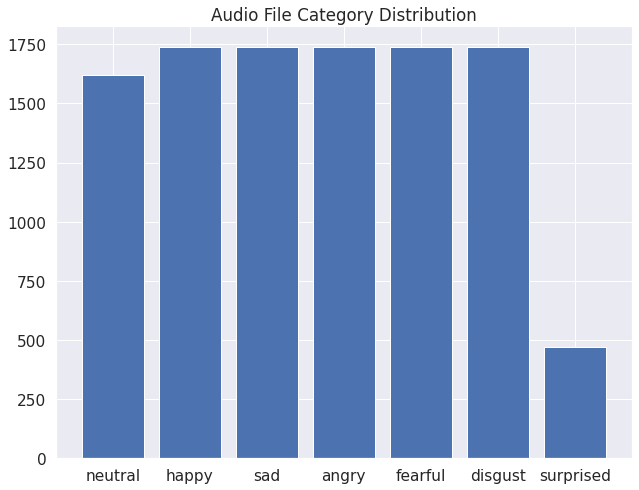

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(emotion,count)
plt.title('Audio File Category Distribution')
plt.show
fig.savefig('drive/MyDrive/SER_charts/' + 'cat_count.jpg')

In [ ]:
# get all files
file_list = []
for folder in sub_folder:
  print('Exporting ' + folder)
  file_list += glob.glob(folder + "/*")

Exporting drive/MyDrive/processed_emotion_dataset/neutral
Exporting drive/MyDrive/processed_emotion_dataset/happy
Exporting drive/MyDrive/processed_emotion_dataset/sad
Exporting drive/MyDrive/processed_emotion_dataset/angry


In [ ]:
!du -sh drive/MyDrive/processed_emotion_dataset/sad

162M	drive/MyDrive/processed_emotion_dataset/sad


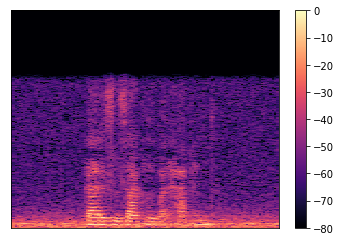

In [ ]:
y, sr = librosa.load('drive/MyDrive/processed_emotion_dataset/sad/sad_1209.wav')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
!ls drive/MyDrive/processed_emotion_dataset/fearful

<function matplotlib.pyplot.show>

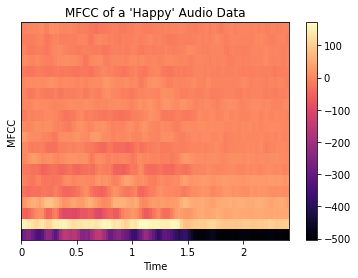

In [ ]:
y, sr = librosa.load('drive/MyDrive/processed_emotion_dataset/happy/happy_323.wav')  
mfccs = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(mfccs, x_axis='time')
plt.title('MFCC of a \'Happy\' Audio Data')
plt.colorbar()
plt.ylabel('MFCC')
plt.set_cmap('magma')
plt.show
# plt.savefig(save_path + 'mfcc_happy_sample.jpg')

<function matplotlib.pyplot.show>

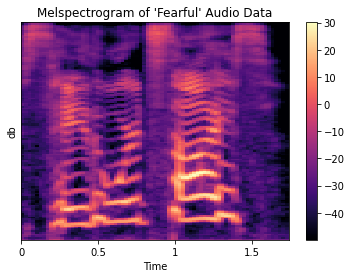

In [ ]:
x, sr = librosa.load('drive/MyDrive/processed_emotion_dataset/fearful/fearful_613.wav')
melspect = librosa.feature.melspectrogram(y=x, sr=sr)
melspect = librosa.power_to_db(melspect, top_db=80.0)
librosa.display.specshow(melspect, x_axis='time')
plt.colorbar()
plt.title('Melspectrogram of \'Fearful\' Audio Data')
plt.ylabel('db')
plt.set_cmap('magma')
plt.show
# plt.savefig(save_path + 'mfcc_fearul_sample.jpg')

# Create Features and Pickle Data

In [ ]:
emotion_class_dict = {"neutral": 0,
                    "happy": 1,
                    "sad": 2,
                    "angry": 3
                    }

In [ ]:
# !ls -1 drive/MyDrive/mel_spec_photos/ | wc -l

# out_path = 'drive/MyDrive/mel_spec_frames/'

Get Zero Crossing

In [ ]:
def get_zero_crossing(y, sr):
  zero_crossing = librosa.feature.zero_crossing_rate(y)
  if zero_crossing.shape[1] > 50:
    zero_crossing = zero_crossing[:,0:50]
  elif zero_crossing.shape[1] < 50:
    pad_length = 50 - zero_crossing.shape[1]
    zero_crossing = np.pad(zero_crossing,(0,pad_length), constant_values=(0,0))
  return zero_crossing

Get Mel Spec

In [ ]:
def get_mel_spec(y, sr):
  melspect = librosa.feature.melspectrogram(y=y, sr=sr)
  melspec_mean = np.mean(melspect, axis=0).reshape(1,-1)
  if melspec_mean.shape[1] > 50:
    melspec_mean = melspec_mean[:,0:50]
  elif melspec_mean.shape[1] < 50:
    pad_length = 50 - melspec_mean.shape[1]
    melspec_mean = np.pad(melspec_mean,(0,pad_length), constant_values=(0,0))
  return melspec_mean

Get MFCC

In [ ]:
def get_mfcc(y, sr):
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  mfcc_mean = np.mean(mfcc, axis=0).reshape(1,-1)
  if mfcc_mean.shape[1] > 50:
    mfcc_mean = mfcc_mean[:,0:50]
  elif mfcc_mean.shape[1] < 50:
    pad_length = 50 - mfcc_mean.shape[1]
    mfcc_mean = np.pad(mfcc_mean,(0,pad_length), constant_values=(0,0))
  return mfcc_mean

Get Spectral Bandwidth

In [ ]:
# extract spectral bandwith
def get_spec_bw(y, sr):
  spec_band = librosa.feature.spectral_bandwidth(y=y, sr=std_sr)
  spec_band = spec_band.reshape(1,-1)
  if spec_band.shape[1] > 50:
    spec_band = spec_band[:,0:50]
  elif spec_band.shape[1] < 50:
    pad_length = 50 - spec_band.shape[1]
    spec_band = np.pad(spec_band,(0,pad_length), constant_values=(0,0))
  return spec_band

In [ ]:
len(file_list)

std_sr = 22050

data_to_pickle = []

for f_name in file_list:
  image_f_name = f_name.split('/')[-1].split('.')[0] + '.jpg'
  category = emotion_class_dict.get(f_name.split('/')[3])
  y, sr = librosa.load(f_name)
  zc = get_zero_crossing(y, std_sr)
  ms = get_mel_spec(y, std_sr)
  mfcc = get_mfcc(y, std_sr)
  spec_bw = get_spec_bw(y, std_sr) 
  audio_arr = np.dstack((zc, ms, mfcc, spec_bw))
  audio_arranged = np.moveaxis(audio_arr,[2,0],[0,1])
  arr = np.array([audio_arranged, category], dtype=object)
  data_to_pickle.append(arr)

with open('drive/MyDrive/emotion_ds_25APRL2022.pkl','wb') as f:
  pickle.dump(data_to_pickle, f)

print('success')

# Create Dataset Class

In [ ]:
class audiodata_cnn(Dataset):
  def __init__(self, pickled_arr):
    self.data = pickled_arr

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    audio_tensor = self.data[index]
    return audio_tensor[0], audio_tensor[1]

In [ ]:
class audiodata_lstm(Dataset):
  def __init__(self, pickled_arr):
    self.data = pickled_arr

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    audio_tensor = self.data[index]
    audio_tensor[0][0] = torch.from_numpy(audio_tensor[0][0])
    audio_tensor[0][1] = torch.from_numpy(audio_tensor[0][1])
    return audio_tensor[0], audio_tensor[1]

# Create Training, Validation, Test Split


In [ ]:
# from torch.utils.data import Subset
# from sklearn.model_selection import train_test_split


In [ ]:
!ls -lah drive/MyDrive/*pkl

-rw------- 1 root root  11M Apr 26 05:59 drive/MyDrive/emotion_ds_25APR2022.pkl
-rw------- 1 root root  64M Apr 26 21:20 drive/MyDrive/emotion_ds_26APR2022_noisier.pkl
-rw------- 1 root root  53M Apr 27 01:27 drive/MyDrive/emotion_ds_26APR2022_noisy_50sec.pkl
-rw------- 1 root root  64M Apr 26 17:14 drive/MyDrive/emotion_ds_26APR2022_noisy.pkl
-rw------- 1 root root  64M Apr 26 16:31 drive/MyDrive/emotion_ds_26APR2022.pkl
-rw------- 1 root root  11M Apr 27 08:03 drive/MyDrive/emotion_ds_27APR2022_20MFCC_noisy.pkl
-rw------- 1 root root  66M Apr 27 09:23 drive/MyDrive/emotion_ds_27APR2022_50Mel_noisy.pkl
-rw------- 1 root root  95M Apr 27 18:49 drive/MyDrive/emotion_ds_27APR2022_noisy_30X60.pkl
-rw------- 1 root root 131M Apr 27 23:35 drive/MyDrive/emotion_ds_27APR2022_noisy_50X50.pkl
-rw------- 1 root root 442M Apr 25 18:35 drive/MyDrive/emotion_ds_4cat.pkl
-rw------- 1 root root 699M Apr 19 20:26 drive/MyDrive/emotion_ds.pkl
-rw------- 1 root root 699M Apr 19 20:27 drive/MyDrive/emoti

In [ ]:
with open('drive/MyDrive/emotion_ds_26APR2022_noisy.pkl','rb') as f:
  audio_arr = pickle.load(f)

In [ ]:
# create cnn dataset 
dataset = audiodata_cnn(audio_arr)
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

train_dl_cnn = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_dl_cnn = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=True)

train_dl_cnn.pin_memory=True

In [ ]:
# create lstm dataset for when training lstm
dataset = audiodata_lstm(audio_arr)
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

train_dl_lstm = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_dl_lstm = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=True)

train_dl_lstm.pin_memory=True

In [ ]:
# check dataset
images, labels = next(iter(train_dl_lstm))
print('original images shape:', images.shape)

original images shape: torch.Size([64, 2, 20, 50])


# Create Models

### CNN 1D

In [ ]:
# create NN model

import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn


class AudioEmotionClassifier(nn.Module):
  def __init__(self, debug=False):
    super(AudioEmotionClassifier, self).__init__()
    self.debug=debug
    
    self.conv_layers = []

    # first convolutional layer
    self.conv1 = nn.Conv1d(4,16,kernel_size=5,stride=2,padding=1)
    self.conv1.bias.data.zero_()
    self.bn1 = nn.BatchNorm1d(16)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)

    self.conv_layers += [self.conv1, self.bn1, self.relu1, self.dropout1]

    # second convolutional layer
    self.conv2 = nn.Conv1d(16,32,kernel_size=5,stride=2,padding=1)
    self.conv2.bias.data.zero_()
    self.bn2 = nn.BatchNorm1d(32)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.5)
    self.conv_layers += [self.conv2, self.bn2, self.relu2, self.dropout2]

    # third convolutional layer
    self.conv3 = nn.Conv1d(32,64,kernel_size=5,stride=2,padding=1)
    self.conv3.bias.data.zero_()
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(0.5)

    self.conv_layers += [self.conv3, self.bn3, self.relu3, self.dropout3]

    # fully connected layer
    self.flatten = nn.Flatten(start_dim=1)
    self.dropoutfc1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(320,128)
    self.dropoutfc2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128,4)

    # Softmax layer
    self.output = nn.LogSoftmax(dim=1)

    self.conv = nn.Sequential(*self.conv_layers)

  def forward(self, x):
    # forward pass
    x = self.conv(x)
    x = self.flatten(x)
    x = self.dropoutfc1(F.relu(self.fc1(x)))
    x = self.dropoutfc2(F.relu(self.fc2(x)))
    x = self.output(x)

    # Final output
    return x


### CNN 1D 2


In [ ]:
# create NN model

import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn


class AudioEmotionClassifier2(nn.Module):
  def __init__(self, debug=False):
    super(AudioEmotionClassifier2, self).__init__()
    self.debug=debug
    
    self.conv_layers = []

    # first convolutional layer
    self.conv1 = nn.Conv1d(4,16,kernel_size=3,stride=2)
    self.bn1 = nn.BatchNorm1d(16)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)

    self.conv_layers += [self.conv1, self.bn1, self.relu1, self.dropout1]

    # second convolutional layer
    self.conv2 = nn.Conv1d(16,32,kernel_size=3,stride=2)
    # self.conv2.bias.data.zero_()
    self.bn2 = nn.BatchNorm1d(32)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.5)
    self.conv_layers += [self.conv2, self.bn2, self.relu2, self.dropout2]

    # third convolutional layer
    self.conv3 = nn.Conv1d(32,64,kernel_size=5,stride=2,padding=1)
    # self.conv3.bias.data.zero_()
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(0.5)

    self.conv_layers += [self.conv3, self.bn3, self.relu3, self.dropout3]

    # fourth convolutional layer
    self.conv4 = nn.Conv1d(128,256,kernel_size=5,stride=2,padding=1)
    # self.conv3.bias.data.zero_()
    self.bn4 = nn.BatchNorm1d(256)
    self.relu4 = nn.ReLU()
    self.dropout4 = nn.Dropout(0.5)

    self.conv_layers += [self.conv4, self.bn4, self.relu4, self.dropout3]


    # fully connected layer
    self.flatten = nn.Flatten(start_dim=1)
    self.dropoutfc1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(512, 4)


    # Softmax layer
    self.output = nn.LogSoftmax(dim=1)

    self.conv = nn.Sequential(*self.conv_layers)

  def forward(self, x):
    # forward pass
    x = self.conv(x)
    x = self.flatten(x)
    x = self.dropoutfc1(F.relu(self.fc1(x)))
    x = self.output(x)

    # Final output
    return x


### CNN 2D

In [ ]:
# create NN model

import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

class AudioEmotionClassifierCNN(nn.Module):
  def __init__(self, debug=False):
    super(AudioEmotionClassifierCNN, self).__init__()
    self.debug=debug

    self.conv_layers = []

    # first convolutional layer
    self.conv1 = nn.Conv2d(2,16,kernel_size=(2,5),stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv1.bias.data.zero_()
    self.dropout1 = nn.Dropout()
    self.relu1 = nn.ReLU()

    self.conv_layers += [self.conv1, self.bn1, self.dropout1, self.relu1]

    # second convolutional layer
    self.conv2 = nn.Conv2d(16,64,kernel_size=(2,5), stride=2)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv2.bias.data.zero_()
    self.dropout2 = nn.Dropout()
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(2,2)

    self.conv_layers += [self.conv2, self.bn2, self.dropout2, self.relu2, self.maxpool2]

    # third convolutional layer
    self.conv3 = nn.Conv2d(64,128,kernel_size=(2,5), stride=2)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv3.bias.data.zero_()
    self.dropout3 = nn.Dropout()
    self.relu3 = nn.ReLU()

    self.conv_layers += [self.conv3, self.bn3, self.dropout3, self.relu3]

    # dropout
    self.fc1 = nn.Dropout()

    # fully connected layer
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128,4)
    self.dropoutfc1 = nn.Dropout()

    # Softmax layer
    self.output = nn.LogSoftmax(dim=1)

    self.conv = nn.Sequential(*self.conv_layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    x = F.relu(self.dropoutfc1(self.fc1(x)))
    x = self.output(x)

    # Final output
    return x


### LSTM

In [ ]:
# https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99/notebook#4.-Multilayer-RNNs-%F0%9F%93%9A
class LSTM_Audio(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size,device, bidirectional=True):
        super(LSTM_Audio, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        
        # Step1: the LSTM model
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # Step2: the FNN
        if bidirectional: # we'll have 2 more layers
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
            
            
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Set initial states
        if self.bidirectional:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size, device=device)
            # Cell state:
            cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size, device=device)
        else:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size, device=device)
            # Cell state:
            cell_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size, device=device)
        if prints: print('hidden_state t0 shape:', hidden_state.shape, '\n' +
                         'cell_state t0 shape:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images, (hidden_state, cell_state))
        # if prints: print('LSTM: output shape:', output.shape, '\n' +
        #                  'LSTM: last_hidden_state shape:', last_hidden_state.shape, '\n' +
        #                  'LSTM: last_cell_state shape:', last_cell_state.shape)
        # # Reshape
        output = output[:, -1, :]
        if prints: print('output reshape:', output.shape)
        
        # FNN:
        output = self.layer(output)
        if prints: print('FNN: Final output shape:', output.shape)
        
        return output

### CNN + LSTM

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size,device, bidirectional=True):
        super(CNN_LSTM, self).__init__()

        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        self.conv_layers = []

    # first convolutional layer
        self.conv1 = nn.Conv2d(2,16,kernel_size=(2,5),stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv1.bias.data.zero_()
        self.dropout1 = nn.Dropout()
        self.relu1 = nn.ReLU()

        self.conv_layers += [self.conv1, self.bn1, self.dropout1, self.relu1]

        # second convolutional layer
        self.conv2 = nn.Conv2d(16,32,kernel_size=(2,5), stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2.bias.data.zero_()
        self.dropout2 = nn.Dropout()
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2,3)

        self.conv_layers += [self.conv2, self.bn2, self.dropout2, self.relu2, self.maxpool2]
            
        self.conv = nn.Sequential(*self.conv_layers)

        self.flatten = nn.Flatten()

        # lstm
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # fc
        if bidirectional: # we'll have 2 more layers
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
            
        # # Softmax layer
        self.output = nn.LogSoftmax(dim=1)

            
    def forward(self, x, prints=False):

        x = self.conv(x)
        x = self.flatten(x)
        x = x[:,None,:]

        if prints:
          print('x shape {}'.format(x.shape))
            
        # Set initial states
        if self.bidirectional:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size*2, x.size(0), self.hidden_size, device=device)
            # Cell state:
            cell_state = torch.zeros(self.layer_size*2, x.size(0), self.hidden_size, device=device)
        else:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size, x.size(0), self.hidden_size, device=device)
            # Cell state:
            cell_state = torch.zeros(self.layer_size, x.size(0), self.hidden_size, device=device)
        if prints: print('hidden_state t0 shape:', hidden_state.shape, '\n' +
                         'cell_state t0 shape:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(x, (hidden_state, cell_state))
        if prints: print('LSTM: output shape:', output.shape, '\n' +
                         'LSTM: last_hidden_state shape:', last_hidden_state.shape, '\n' +
                         'LSTM: last_cell_state shape:', last_cell_state.shape)
        # Reshape
        output = output[:, -1, :]
        if prints: print('output reshape:', output.shape)
        
        # FNN:
        output = self.layer(output)

        if prints: print('FNN: Final output shape:', output.shape)
        
        x = self.output(output)

        return output

# Create Train, Test Functions

In [ ]:
def train_epoch(model, device, dataloader, loss_fn, optimizer, scheduler, verbose=False, lstm=False):
    train_loss = 0.0
    correct_pred = 0
    total_pred = 0
    if lstm:
        model.train()
    for tensor, class_label in dataloader:

        inputs, labels = tensor.to(device), class_label.to(device)
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()
        pred_prob = model(inputs)
        loss = loss_fn(pred_prob, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        _, predicted_class = torch.max(pred_prob, 1)

        correct_pred += (predicted_class == labels).sum().item()
        total_pred += predicted_class.shape[0]

    avg_loss = train_loss / len(dataloader)
    accuracy = correct_pred / total_pred

    if verbose:
        print(f"Train Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


In [ ]:
def test_epoch(model, device, dataloader, loss_fn, verbose=False):
    model.eval()
    test_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            pred_prob = model(inputs)

            # Keep stats for Loss and Accuracy
            loss = loss_fn(pred_prob, labels)
            test_loss += loss

            # get highest prediction class
            _, prediction = torch.max(pred_prob,1)

            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        # Print stats at the end of the epoch
        avg_loss = test_loss / len(dataloader)
        accuracy = correct_prediction/total_prediction      
    
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy       



# Training

In [ ]:
# use cuda
torch.cuda.get_device_name(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

### CNN

In [ ]:
# create instance of model of CNN
AudioEmotionClassifierModelCNN = AudioEmotionClassifierCNN()
AudioEmotionClassifierModelCNN = AudioEmotionClassifierModelCNN.to(device)
next(AudioEmotionClassifierModelCNN.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in AudioEmotionClassifierModelCNN.state_dict():
    print(param_tensor, "\t", AudioEmotionClassifierModelCNN.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([16, 2, 2, 5])
conv1.bias 	 torch.Size([16])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
bn1.running_mean 	 torch.Size([16])
bn1.running_var 	 torch.Size([16])
bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([64, 16, 2, 5])
conv2.bias 	 torch.Size([64])
bn2.weight 	 torch.Size([64])
bn2.bias 	 torch.Size([64])
bn2.running_mean 	 torch.Size([64])
bn2.running_var 	 torch.Size([64])
bn2.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([128, 64, 2, 5])
conv3.bias 	 torch.Size([128])
bn3.weight 	 torch.Size([128])
bn3.bias 	 torch.Size([128])
bn3.running_mean 	 torch.Size([128])
bn3.running_var 	 torch.Size([128])
bn3.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([4, 128])
fc1.bias 	 torch.Size([4])
conv.0.weight 	 torch.Size([16, 2, 2, 5])
conv.0.bias 	 torch.Size([16])
conv.1.weight 	 torch.Size([16])
conv.1.bias 	 torch.Size([16])
conv.1.running_mean 	 torch.Size([16])
conv.1.runni

In [ ]:
# training cnn
num_epochs = 15
lr = 0.001
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(AudioEmotionClassifierModelCNN.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                steps_per_epoch=int(len(train_dl_cnn)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

train_test_loss = {'train_loss':[],'val_loss':[]}
train_test_accuracy = {'train_accuracy':[],'val_accuracy':[]}

for epoch in range(num_epochs):
    print('Epoch {}'.format(epoch + 1))
    train_loss, train_acc = train_epoch(AudioEmotionClassifierModelCNN, device, train_dl_cnn, criterion, optimizer, scheduler, lstm=False)
    test_loss, test_acc = test_epoch(AudioEmotionClassifierModelCNN, device, val_dl_cnn, criterion) 
    train_test_loss['train_loss'].append(train_loss)
    train_test_accuracy['train_accuracy'].append(train_acc)
    train_test_loss['val_loss'].append(test_loss.cpu())
    train_test_accuracy['val_accuracy'].append(test_acc)
    print('Train loss: {:.2f}, Test Loss'.format(train_loss, test_loss))
    print('Train accuracy: {:.2f}, Test accuracy {:.2f}'.format(train_acc, test_acc))
    print('___________________________')


Epoch 1
Train loss: 1.46, Test Loss
Train accuracy: 0.25, Test accuracy 0.28
___________________________
Epoch 2
Train loss: 1.23, Test Loss
Train accuracy: 0.46, Test accuracy 0.57
___________________________
Epoch 3
Train loss: 0.95, Test Loss
Train accuracy: 0.60, Test accuracy 0.65
___________________________
Epoch 4
Train loss: 0.82, Test Loss
Train accuracy: 0.64, Test accuracy 0.67
___________________________
Epoch 5
Train loss: 0.77, Test Loss
Train accuracy: 0.66, Test accuracy 0.70
___________________________
Epoch 6
Train loss: 0.71, Test Loss
Train accuracy: 0.69, Test accuracy 0.68
___________________________
Epoch 7
Train loss: 0.69, Test Loss
Train accuracy: 0.70, Test accuracy 0.71
___________________________
Epoch 8
Train loss: 0.66, Test Loss
Train accuracy: 0.72, Test accuracy 0.70
___________________________
Epoch 9
Train loss: 0.64, Test Loss
Train accuracy: 0.74, Test accuracy 0.69
___________________________
Epoch 10
Train loss: 0.61, Test Loss
Train accuracy: 0.

#### Evaluation Metrics

In [ ]:
save_path = 'drive/MyDrive/SER_charts/'

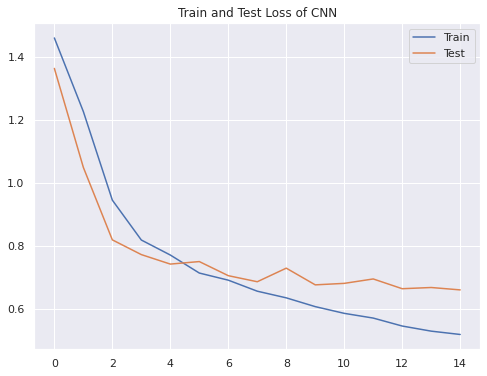

In [ ]:
sn.set()
fig = plt.figure(figsize=(8,6))
plt.title('Train and Test Loss of CNN')
plt.plot(range(epoch+1),train_test_loss['train_loss'], label = 'Train')
plt.plot(range(epoch+1), train_test_loss['val_loss'], label = 'Test')
plt.legend()
plt.show()
# fig = plt.savefig(save_path + 'Train_Test_loss_cnn.png')

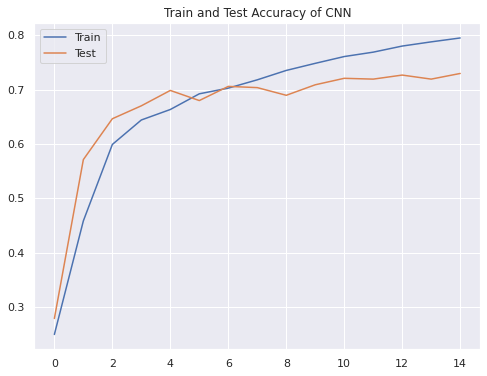

In [ ]:
fig1 = plt.figure(figsize=(8,6))
plt.title('Train and Test Accuracy of CNN')
plt.plot(range(epoch+1),train_test_accuracy['train_accuracy'], label = 'Train')
plt.plot(range(epoch+1), train_test_accuracy['val_accuracy'], label = 'Test')
plt.legend()
plt.show()
# fig1.savefig(save_path + 'Train_test_acc_CNN.png')

In [ ]:
# # # save model
# model_path = 'drive/MyDrive/audio_emotion_CNN27APR2022_Final.pt'
# torch.save(AudioEmotionClassifierModelCNN.state_dict(), model_path)

In [ ]:
# get confusion matrix
def get_eval_met(model, dataloader):
    model.eval()

    pred, actuals = [], []

    with torch.no_grad():
        for data in dataloader:
            temp_list =[]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            pred_prob = model(inputs)

            # get highest prediction class
            _, prediction = torch.max(pred_prob,1)
            prediction_cpu = prediction.data.cpu()
      
            
            pred_list = [i.cpu().item() for i in prediction]
            label_list = [i.cpu().item() for i in labels]

            pred += pred_list
            actuals += label_list

    acc = sklearn.metrics.accuracy_score(actuals, pred)
    prf = sklearn.metrics.precision_recall_fscore_support(actuals, pred, labels=[0,1,2,3], average="macro")
    cm = sklearn.metrics.confusion_matrix(pred, actuals)
    return acc, prf, cm


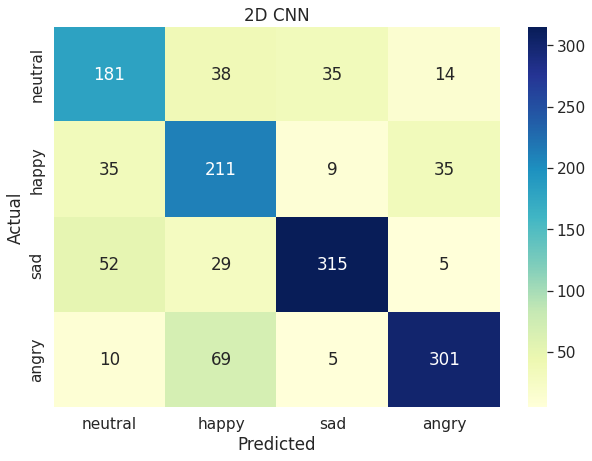

0.75
(0.7425784206610223, 0.7431050600710136, 0.7406317412619933, None)


In [ ]:
acc, prf, cm = get_eval_met(AudioEmotionClassifierModelCNN, val_dl_cnn)
df_cm_CNN = pd.DataFrame(cm,
                            index=["neutral", "happy", "sad", "angry"],
                            columns=["neutral", "happy", "sad", "angry"])


fig = plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm_CNN, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("2D CNN")
plt.show()
fig.savefig(save_path + 'CM_CNN.jpg')

print(acc)
print(prf)

### CNN-LSTM

In [ ]:
# create instance of model of LSTM
batch_size = 64
input_size = 256
hidden_size = 128
layer_size = 1       
output_size = 4

AudioEmotionClassifierModel_LSTM = CNN_LSTM(input_size, hidden_size, layer_size, output_size, device)
AudioEmotionClassifierModel_LSTM = AudioEmotionClassifierModel_LSTM.to(device)
next(AudioEmotionClassifierModel_LSTM.parameters()).device


device(type='cuda', index=0)

In [ ]:
# training cnn
num_epochs = 100
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AudioEmotionClassifierModel_LSTM.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                steps_per_epoch=int(len(train_dl_cnn)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

train_test_loss = {'train_loss':[],'val_loss':[]}
train_test_accuracy = {'train_accuracy':[],'val_accuracy':[]}

for epoch in range(num_epochs):
    print('Epoch {}'.format(epoch + 1))
    train_loss, train_acc = train_epoch(AudioEmotionClassifierModel_LSTM, device, train_dl_cnn, criterion, optimizer, scheduler, lstm=True)
    test_loss, test_acc = test_epoch(AudioEmotionClassifierModel_LSTM, device, val_dl_cnn, criterion) 
    train_test_loss['train_loss'].append(train_loss)
    train_test_accuracy['train_accuracy'].append(train_acc)
    train_test_loss['val_loss'].append(test_loss.cpu())
    train_test_accuracy['val_accuracy'].append(test_acc)
    print('Train loss: {:.2f}, Test Loss {:.2f}'.format(train_loss, test_loss))
    print('Train accuracy: {:.2f}, Test accuracy {:.2f}'.format(train_acc, test_acc))
    print('___________________________')


Epoch 1
Train loss: 1.37, Test Loss 1.35
Train accuracy: 0.31, Test accuracy 0.46
___________________________
Epoch 2
Train loss: 1.32, Test Loss 1.26
Train accuracy: 0.41, Test accuracy 0.51
___________________________
Epoch 3
Train loss: 1.21, Test Loss 1.13
Train accuracy: 0.46, Test accuracy 0.53
___________________________
Epoch 4
Train loss: 1.12, Test Loss 1.02
Train accuracy: 0.51, Test accuracy 0.60
___________________________
Epoch 5
Train loss: 1.05, Test Loss 0.94
Train accuracy: 0.55, Test accuracy 0.63
___________________________
Epoch 6
Train loss: 1.00, Test Loss 0.88
Train accuracy: 0.59, Test accuracy 0.65
___________________________
Epoch 7
Train loss: 0.95, Test Loss 0.84
Train accuracy: 0.60, Test accuracy 0.66
___________________________
Epoch 8
Train loss: 0.91, Test Loss 0.79
Train accuracy: 0.61, Test accuracy 0.66
___________________________
Epoch 9
Train loss: 0.88, Test Loss 0.76
Train accuracy: 0.63, Test accuracy 0.67
___________________________
Epoch 10
T

#### Evaluation Metrics

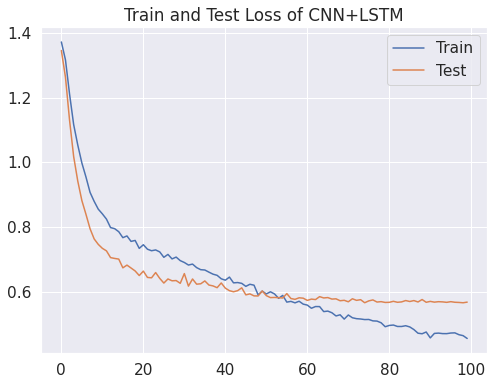

<Figure size 432x288 with 0 Axes>

In [ ]:
fig3 = plt.figure(figsize=(8,6))
plt.title('Train and Test Loss of CNN+LSTM')
plt.plot(range(epoch+1),train_test_loss['train_loss'], label = 'Train')
plt.plot(range(epoch+1), train_test_loss['val_loss'], label = 'Test')
plt.legend()
plt.show()
fig3 = plt.savefig(save_path + 'Train_Test_loss_cnnlstm.png')

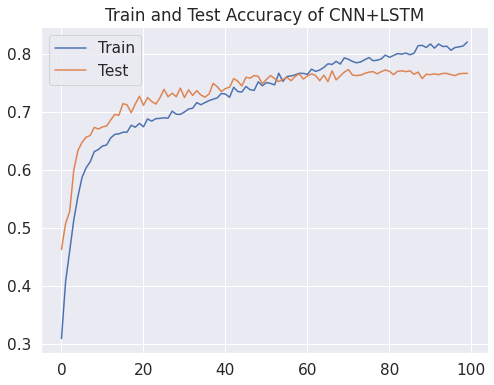

<Figure size 432x288 with 0 Axes>

In [ ]:
fig4 = plt.figure(figsize=(8,6))
plt.title('Train and Test Accuracy of CNN+LSTM')
plt.plot(range(epoch+1),train_test_accuracy['train_accuracy'], label = 'Train')
plt.plot(range(epoch+1), train_test_accuracy['val_accuracy'], label = 'Test')
plt.legend()
plt.show()
fig4 = plt.savefig(save_path + 'Train_Test_acc_cnnlstm.jpg')

In [ ]:
# # save model
# model_path = 'drive/MyDrive/audio_emotion_LSTM27APR2022_Final.pt'
# torch.save(AudioEmotionClassifierModel_LSTM.state_dict(), model_path)

In [ ]:
# get confusion matrix
def get_eval_met(model, dataloader):
    model.eval()

    pred, actuals = [], []

    with torch.no_grad():
        for data in dataloader:
            temp_list =[]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            pred_prob = model(inputs)

            # get highest prediction class
            _, prediction = torch.max(pred_prob,1)
            prediction_cpu = prediction.data.cpu()
      
            
            pred_list = [i.cpu().item() for i in prediction]
            label_list = [i.cpu().item() for i in labels]

            pred += pred_list
            actuals += label_list

    acc = sklearn.metrics.accuracy_score(actuals, pred)
    prf = sklearn.metrics.precision_recall_fscore_support(actuals, pred, labels=[0,1,2,3], average="macro")
    cm = sklearn.metrics.confusion_matrix(pred, actuals)
    return acc, prf, cm


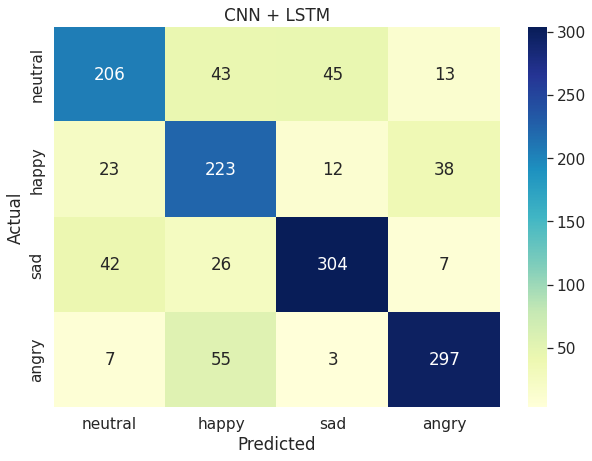

0.7663690476190477
(0.7617352393143944, 0.7638607611373174, 0.7611632996461365, None)


In [ ]:
acc, prf, cm = get_eval_met(AudioEmotionClassifierModel_LSTM, val_dl_cnn)
df_cm_CNN = pd.DataFrame(cm,
                            index=["neutral", "happy", "sad", "angry"],
                            columns=["neutral", "happy", "sad", "angry"])


fig = plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm_CNN, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN + LSTM")
plt.show()
fig.savefig(save_path + 'LSTM_CNN.jpg')

print(acc)
print(prf)

# Testing with Custom Audio Recordings

In [ ]:
!ls drive/MyDrive/neutral.wav

drive/MyDrive/neutral.wav


In [ ]:
# # load only when model has been trained
# AudioEmotionClassifierModel = AudioEmotionClassifier()
# AudioEmotionClassifierModel = AudioEmotionClassifierModel.to(device)
# AudioEmotionClassifierModel.load_state_dict(torch.load('drive/MyDrive/audio_emotion_model19APR2022.pt'))

In [ ]:
!ls drive/MyDrive/processed_emotion_dataset/sad

In [ ]:
test_path = 'drive/MyDrive/processed_emotion_dataset/angry/angry_429.wav'

In [ ]:
emotion_class_keys = { 0: "neutral",
                    1 : "happy",
                    2 : "sad",
                    3 : "angry"
                    }

In [ ]:
x, sr = librosa.load(test_path)
sr = 22050
mfcc = librosa.feature.mfcc(y=x, sr=sr)
pad_crop_length = 50 - mfcc.shape[1]
if pad_crop_length > 0:
    mfcc = np.pad(mfcc, [(0, 0), (0, pad_crop_length)], mode='constant')
elif pad_crop_length < 0:
    mfcc = mfcc[:, 0:50]
melspect = librosa.feature.melspectrogram(y=x, sr=sr,)
pad_crop_length = 50 - melspect.shape[1]
if pad_crop_length > 0:
    melspect = np.pad(melspect, [(0, 0), (0, pad_crop_length)], mode='constant')
elif pad_crop_length < 0:
    melspect = melspect[:, 0:50]
melspect = librosa.power_to_db(melspect, top_db=80.0)
melspect = melspect[0:20,]
audio_arr = np.dstack((mfcc, melspect))
audio_arr = np.moveaxis(audio_arr, [2, 0], [0, 1])
tensor = torch.from_numpy(audio_arr).to(device)

pred = AudioEmotionClassifierModelCNN(tensor[None,:,:,:])
_, class_emotion = torch.max(pred,1)
emotion_class_keys.get(class_emotion.data.item())

'neutral'